In [1]:
!pip install keras-tuner --upgrade

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os
import zipfile
import matplotlib.image as mpimg
import keras_tuner as kt
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import itertools



In [ ]:
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total  --format=csv

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
dados_crus = pd.read_csv('/content/drive/MyDrive/PF_Joao_Tupinamba/Teste_GPU/OutPut5Corr.csv',sep = ';', header=0)
dados_crus = dados_crus.iloc[:, [1,2,3,4,5,7,8,10,12,19,20,21,-1,-2]]

## Normal Dataset (Filtrado)

In [4]:
V1 = np.array(dados_crus.pop('Semenov'))
V2 = np.array(dados_crus.pop('T_Limite'))

Labels = []
for i in range(len(V1)):
  if V1[i] > 0 or V2[i]> 0:
    Labels.append(1)
  else:
    Labels.append(0)
Labels = np.array(Labels)

dados_crus['Labels'] = Labels
df_runaway = dados_crus.query('Labels > 0')


In [5]:
test_dataset_runaway = df_runaway.sample(n=round(dados_crus.shape[0]*0.01*0.5), random_state=1) #metade do teste feito de operações que geraram runaway

NormalOp = dados_crus.drop(df_runaway.index) #ou .query

test_dataset_NormalOp = NormalOp.sample(n=round(dados_crus.shape[0]*0.01*0.5), random_state=1) #outra metade com instâncias comuns de operação

Test_dataset = pd.concat([test_dataset_runaway,test_dataset_NormalOp])

Train_dataset = dados_crus.drop(Test_dataset.index)


Test_dataset_Labels = Test_dataset.pop('Labels')

Train_dataset_Labels = Train_dataset.pop('Labels')


In [6]:
dados_crus

,Tempo,Conc,T_Reator,T_Jaqueta,Ff,Te,Tej,Ca0,Hrec,Ffj,Qm,Qr,Labels
0,0.000000,2.000000,311.150000,255.000000,56.0,289.15,256.15,2,-89700,2.032484,18.037788,135.694981,0
1,0.606061,1.978296,310.158835,256.878295,56.0,289.15,256.15,2,-89700,2.032484,16.253297,129.292939,0
2,1.212121,1.957900,309.208465,258.652581,56.0,289.15,256.15,2,-89700,2.032484,14.701465,123.177082,0
3,1.818182,1.938686,308.298080,260.328167,56.0,289.15,256.15,2,-89700,2.032484,13.347991,117.338962,0
4,2.424242,1.920547,307.426707,261.910131,56.0,289.15,256.15,2,-89700,2.032484,12.164007,111.769557,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4665595,57.575758,0.000003,826.348368,640.584410,56.0,289.15,256.15,2,-89700,2.032484,1968.714435,2306.585250,1
4665596,58.181818,0.000003,826.373689,640.836846,56.0,289.15,256.15,2,-89700,2.032484,1968.714442,2306.493621,1
4665597,58.787879,0.000003,826.397789,641.077153,56.0,289.15,256.15,2,-89700,2.032484,1968.714452,2306.406366,1
4665598,59.393939,0.000003,826.420725,641.305916,56.0,289.15,256.15,2,-89700,2.032484,1968.714456,2306.323278,1


# Dataset_PCA

In [6]:
dados_crus = pd.read_csv('/content/drive/MyDrive/PF_Joao_Tupinamba/Teste_GPU/OutPut5Corr.csv',sep = ';', header=0)
dados_crus = dados_crus.iloc[:, [1,2,3,4,5,7,8,10,12,19,20,21,-1,-2]]

dados_crus.drop(['Semenov','T_Limite'],axis=1)

X_reduced = pd.DataFrame(dados_crus)
pca = PCA(n_components=5)
X_reduced = pd.DataFrame(pca.fit_transform(X_reduced))

X_reduced['Labels'] = Labels

df_runaway_PCA = X_reduced.query('Labels > 0')


test_dataset_runaway_PCA = df_runaway_PCA.sample(n=round(X_reduced.shape[0]*0.01*0.5), random_state=1) #metade do teste feito de operações que geraram runaway

NormalOp_PCA = X_reduced.drop(df_runaway_PCA.index) #ou .query

test_dataset_NormalOp_PCA = NormalOp_PCA.sample(n=round(X_reduced.shape[0]*0.01*0.5), random_state=1) #outra metade com instâncias comuns de operação

Test_dataset_PCA = pd.concat([test_dataset_runaway_PCA,test_dataset_NormalOp_PCA])

Train_dataset_PCA = X_reduced.drop(Test_dataset_PCA.index)

Test_dataset_PCA_Labels = Test_dataset_PCA.pop('Labels')

Train_dataset_PCA_Labels = Train_dataset_PCA.pop('Labels')


# Cont

In [ ]:
test_dataset_runaway.shape

(23328, 13)

In [ ]:
test_dataset_NormalOp.shape

(23328, 13)

In [ ]:
Test_dataset.shape

(46656, 12)

In [ ]:
Test_dataset_PCA.shape

(46656, 5)

In [ ]:
dados_crus.shape

(4665600, 14)

In [ ]:
Test_dataset.shape[0]+Train_dataset.shape[0]

4665600

In [ ]:
len(Labels)

4665600

## Um treino qualquer

In [ ]:
model=keras.Sequential()

model.add(keras.layers.Dense(64,input_shape=[12],
                             bias_regularizer=regularizers.l1(1e-3),
                             activation = 'LeakyReLU'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(32,activation = 'LeakyReLU'))

model.add(keras.layers.Dense(16,bias_regularizer=regularizers.l1(1e-3),
                             activation = 'LeakyReLU'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(16,activation = 'LeakyReLU'))

model.add(keras.layers.Dense(32,bias_regularizer=regularizers.l1(1e-3),
                             activation = 'LeakyReLU'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(16,activation = 'LeakyReLU'))



model.add(keras.layers.Dense(1, activation='sigmoid'))

  


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                832       
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                5

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-6),loss='binary_crossentropy',metrics=['mae','mse','accuracy'])

In [ ]:
history = model.fit(x=Train_dataset,y=Train_dataset_Labels,validation_data = (Test_dataset,Test_dataset_Labels)
                    ,validation_steps = len(Test_dataset)/400 ,epochs = 20 ,batch_size=400,verbose=1
                    )

In [ ]:
for i in ['loss', 'mae', 'mse', 'accuracy']:
  plt.plot(history.history[i])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

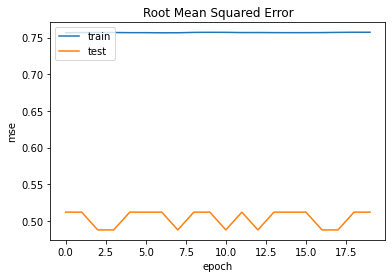

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_mse'])
plt.title('Root Mean Squared Error')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Keras Tuner

In [7]:
def build_model(hp):
  model = keras.Sequential()

  model.add(keras.layers.Dense(
        hp.Choice('unitsPre1', [32, 64,128]),
        bias_regularizer=regularizers.l1(1e-4),
        activation='LeakyReLU'))
  
  model.add(keras.layers.Dense(
      hp.Choice('unitsPre2', [32, 64,128]),
      bias_regularizer=regularizers.l1(1e-4),
      activation='LeakyReLU'))
  
  for i in range(hp.Int('num_layers',4,8)):
    if i % 2 == 0:
      model.add(keras.layers.Dense(
        hp.Choice('units' + str(i), [16, 32, 64]),
        bias_regularizer=regularizers.l1(1e-4),
        activation='LeakyReLU'))
      model.add(keras.layers.BatchNormalization())
    else:
      model.add(keras.layers.Dense(
          hp.Choice('units' + str(i), [16, 32]),
          activation='LeakyReLU'))
      
  
  model.add(keras.layers.Dense(1, activation='sigmoid'))

  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',[1e-5,1e-6])),loss='binary_crossentropy',metrics=['mae','mse','accuracy'])
  #model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.001
   #                                                   ,initial_accumulator_value=0.1,epsilon=1e-07,name="Adagrad"),loss='binary_crossentropy',metrics=['mae','mse','accuracy'])
  
  return model

In [8]:
tuner = kt.Hyperband(build_model,
                     objective=kt.Objective("val_accuracy", direction="max"),
                     max_epochs=8,
                     factor=6,
                     directory='/content/drive/MyDrive/PF_Joao_Tupinamba/Teste GPU/',
                     project_name='Reactor_NN_Tuner_Hyperband+2',
                     overwrite=False)
#tuner.search(Train_dataset_PCA, Train_dataset_PCA_Labels,
#             validation_data=(Test_dataset_PCA, Test_dataset_PCA_Labels),
#             validation_steps = len(Test_dataset)/400 ,batch_size=400)
#tuner.get_best_models()

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/PF_Joao_Tupinamba/Teste GPU/Reactor_NN_Tuner_Hyperband+2/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/PF_Joao_Tupinamba/Teste GPU/Reactor_NN_Tuner_Hyperband+2/tuner0.json


In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_accuracy", direction="max"),
    executions_per_trial=1,
    max_trials=40,
    directory ='/content/drive/MyDrive/PF_Joao_Tupinamba/Teste GPU/',
    project_name='Reactor_NN_Tuner2',
    overwrite = True)

#tuner.search(Train_dataset_PCA, Train_Labels, 
#             epochs=5, validation_data=(Test_dataset_PCA, Test_Labels),
#             validation_steps = len(Test_dataset)/400 ,batch_size=400)


[]

In [12]:
tuner.results_summary()

Results summary
Results in /content/drive/MyDrive/PF_Joao_Tupinamba/Teste GPU/Reactor_NN_Tuner_Hyperband+2
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
unitsPre1: 32
unitsPre2: 64
num_layers: 7
units0: 16
units1: 32
units2: 16
units3: 16
learning_rate: 1e-05
units4: 16
units5: 32
units6: 16
units7: 16
tuner/epochs: 8
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: d816f1bbcd21a1c8c83d7ecfbca6dbd1
Score: 0.925947368144989
Trial summary
Hyperparameters:
unitsPre1: 32
unitsPre2: 128
num_layers: 8
units0: 16
units1: 16
units2: 16
units3: 32
learning_rate: 1e-05
units4: 16
units5: 16
units6: 64
tuner/epochs: 8
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
units7: 16
tuner/trial_id: 43ce4b75b2ce6b3af57c3b9dc59d6b05
Score: 0.9250471591949463
Trial summary
Hyperparameters:
unitsPre1: 64
unitsPre2: 128
num_layers: 5
units0: 16
units1: 16
units2: 32
units3: 32
learning_rate: 1e-05
units4: 32
units5: 16
units

In [9]:
best_hps=tuner.get_best_hyperparameters(num_trials=20)[4]
model = tuner.hypermodel.build(best_hps)
#model.load_weights(tf.train.latest_checkpoint('/content/drive/MyDrive/PF_Joao_Tupinamba/Teste GPU/Reactor_NN_Tuner_Hyperband+2/trial_d816f1bbcd21a1c8c83d7ecfbca6dbd1/checkpoints/epoch_0'))
model.build((Train_dataset_PCA.shape[0],5))


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (4618944, 32)             192       
_________________________________________________________________
dense_1 (Dense)              (4618944, 64)             2112      
_________________________________________________________________
dense_2 (Dense)              (4618944, 16)             1040      
_________________________________________________________________
batch_normalization (BatchNo (4618944, 16)             64        
_________________________________________________________________
dense_3 (Dense)              (4618944, 32)             544       
_________________________________________________________________
dense_4 (Dense)              (4618944, 16)             528       
_________________________________________________________________
batch_normalization_1 (Batch (4618944, 16)             6

In [11]:
# É melhor treinar novamente ao invés de carregar os pesos do tuner
history = model.fit(x=Train_dataset_PCA,y=Train_dataset_PCA_Labels,validation_data = (Test_dataset_PCA,Test_dataset_PCA_Labels)
                    ,validation_steps = len(Test_dataset)/400 ,epochs = 8 ,batch_size=400,verbose=1
                    )

Epoch 1/8
11548/11548 [==============================] - 65s 5ms/step - loss: 0.2338 - mae: 0.1732 - mse: 0.0658 - accuracy: 0.9202 - val_loss: 0.2365 - val_mae: 0.1668 - val_mse: 0.0707 - val_accuracy: 0.9078
Epoch 2/8
11548/11548 [==============================] - 63s 5ms/step - loss: 0.1466 - mae: 0.0953 - mse: 0.0441 - accuracy: 0.9374 - val_loss: 0.3845 - val_mae: 0.2184 - val_mse: 0.1277 - val_accuracy: 0.8205
Epoch 3/8
11548/11548 [==============================] - 63s 5ms/step - loss: 0.1370 - mae: 0.0871 - mse: 0.0425 - accuracy: 0.9386 - val_loss: 0.2598 - val_mae: 0.1735 - val_mse: 0.0834 - val_accuracy: 0.8809
Epoch 4/8
11548/11548 [==============================] - 63s 5ms/step - loss: 0.1316 - mae: 0.0840 - mse: 0.0412 - accuracy: 0.9400 - val_loss: 0.2677 - val_mae: 0.1754 - val_mse: 0.0882 - val_accuracy: 0.8700
Epoch 5/8
11548/11548 [==============================] - 63s 5ms/step - loss: 0.1275 - mae: 0.0815 - mse: 0.0401 - accuracy: 0.9413 - val_loss: 0.1763 - val_mae

In [20]:
#Daí então você salva os pesos bem treinados:
model.save_weights('/content/drive/MyDrive/PF_Joao_Tupinamba/Teste GPU/Pesos_Modelo_otimo.h5', overwrite=False)


In [22]:
#E pode carregá-los:
model.load_weights('/content/drive/MyDrive/PF_Joao_Tupinamba/Teste GPU/Pesos_Modelo_otimo.h5')


## Confusion matrix

In [25]:
def plot_confusion_matrix(cm, classes,
                        normalize=True,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(16, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.94354424 0.05645576]
 [0.09006344 0.90993656]]


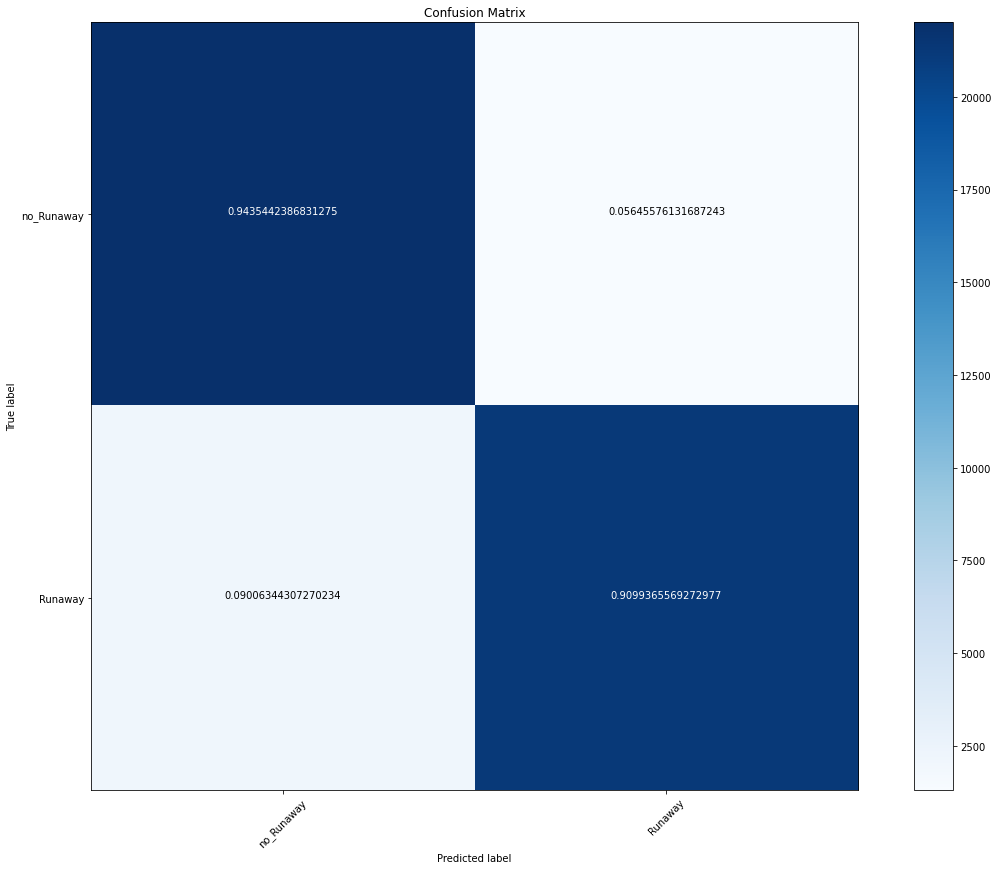

In [26]:
predictions = model.predict(
      x=Test_dataset_PCA
    , batch_size=400
    , verbose=0
)  

rounded_predictions = np.argmax(predictions, axis=-1)

cm = confusion_matrix(y_true=Test_dataset_PCA_Labels, y_pred=predictions.round())
cm_plot_labels = ['no_Runaway','Runaway']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
